In [1]:
import os
import glob

import numpy as np
from nilearn import image
from nilearn import datasets
from nilearn.plotting import plot_carpet

import nilearn
from nilearn import plotting
from nilearn import image
from nilearn.maskers import NiftiMasker
from nilearn import masking
from nilearn.plotting import plot_carpet

from nltools.data import Brain_Data

import nibabel as nib

import matplotlib.pyplot as plt
from PIL import Image

# ignore warnings - if you want to reset, run warnings.resetwarnings()
import warnings
warnings.simplefilter('ignore',UserWarning)

In [2]:
# initialize subject list for file naming
num_of_subjects = 10 
num_of_runs = 2
excluded = [7,8]
subject_list = ["{:02d}".format(i) for i in range(1,num_of_subjects+1) if i not in excluded]
# initialize pipeline datafolders
# make sure you change the paths according to your computer
pp = r"/home/anakin/Desktop/ds000113/output/preprocessing" 
level1 = r"/home/anakin/Desktop/ds000113/output/1st_level" 
level2 = r"/home/anakin/Desktop/ds000113/output/2nd_level" 
level3 = r"/home/anakin/Desktop/ds000113/output/3rd_level"

In [3]:
# preprocessing validation

In [4]:
# plot epi for each subject (2 runs)
# the epi image (echo planner imaging, read more here: https://mriquestions.com/echo-planar-imaging.html)
# is basically the functional file (4D) averaged across time: 
# the product is each voxel's mean signal in that run. these are arbitrary units scaled by magnitude.
# what wer'e looking for is diffrences in tissues - 
# CSF, gray and white matter differs in mean signal. 
# when examining within gray matter in passive viewing - we might expect to see audiovisual areas (mainly) 
# we will also check that all are oriented in the same way, a common issue in neuroimaging.

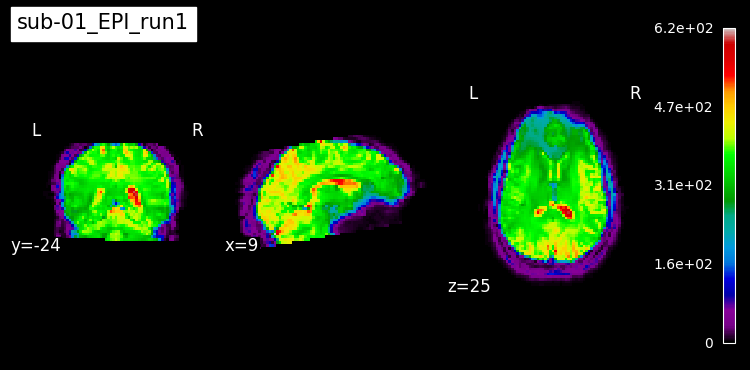

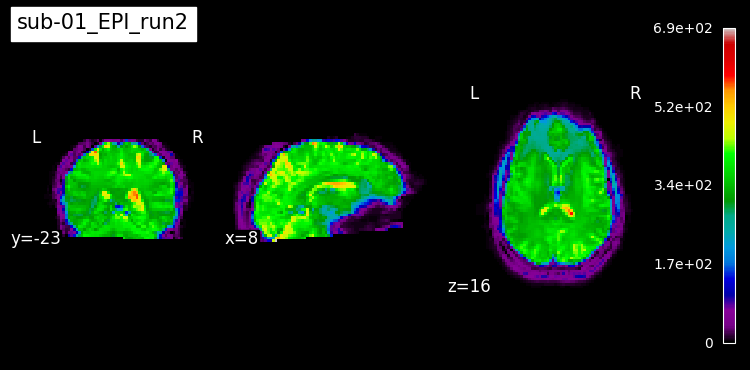

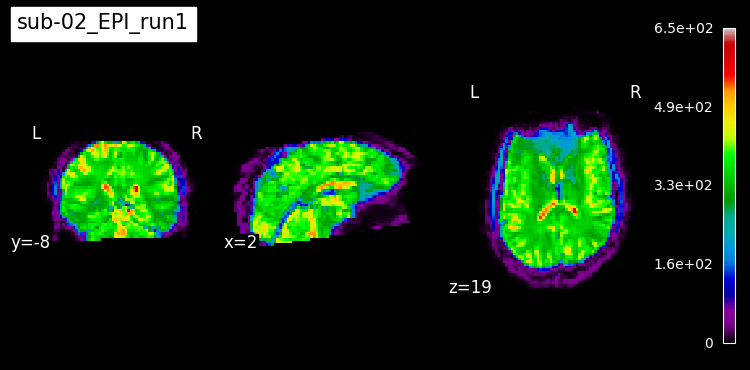

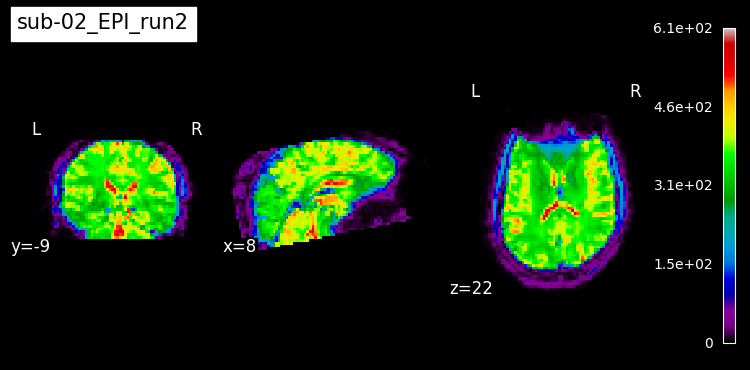

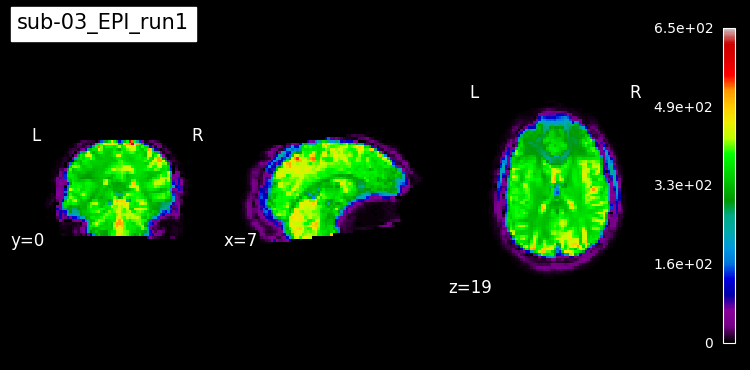

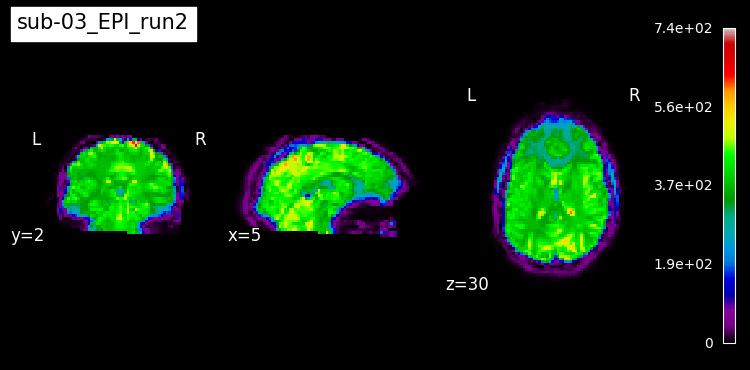

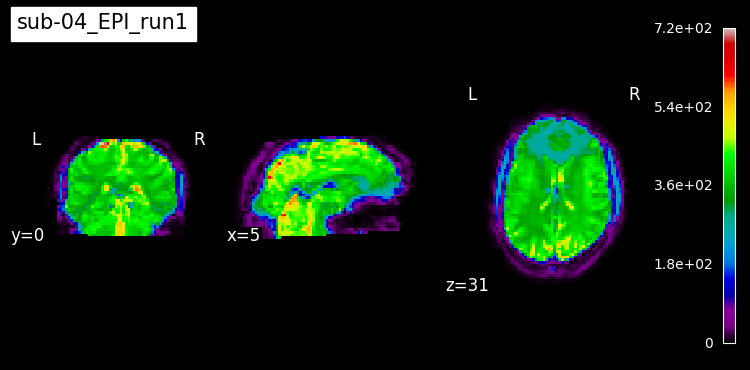

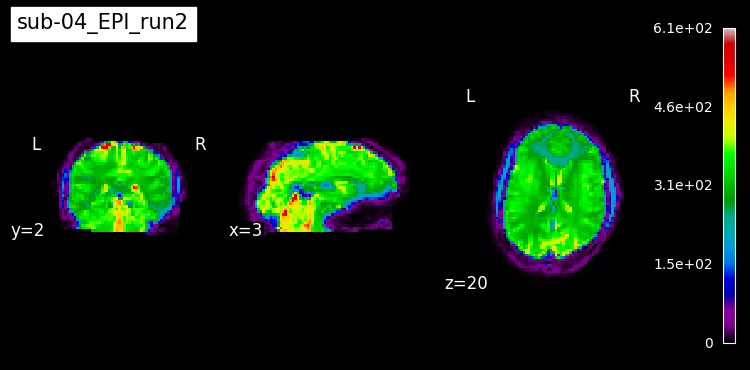

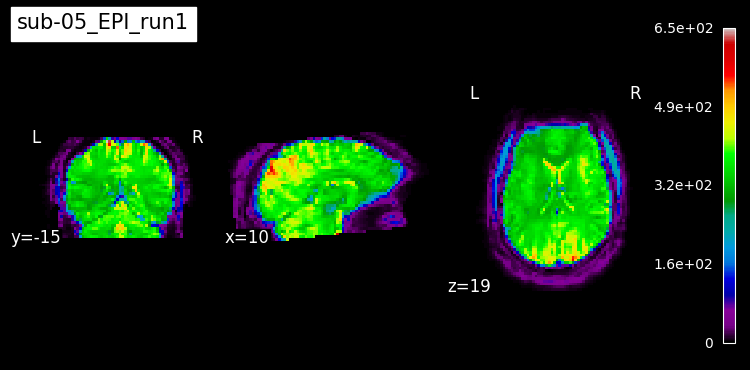

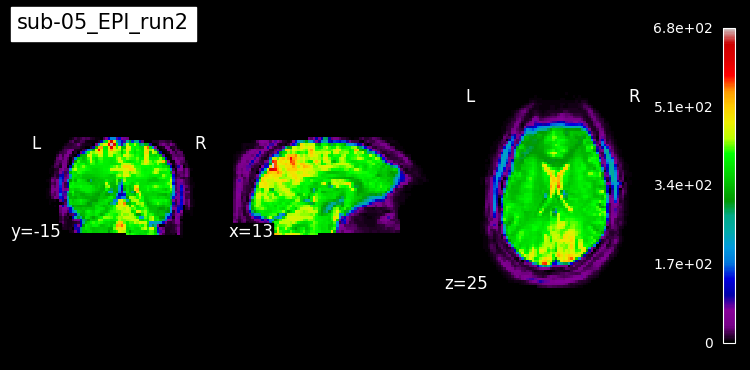

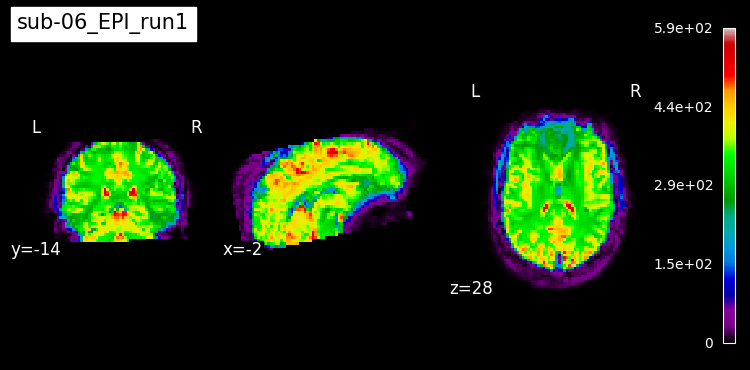

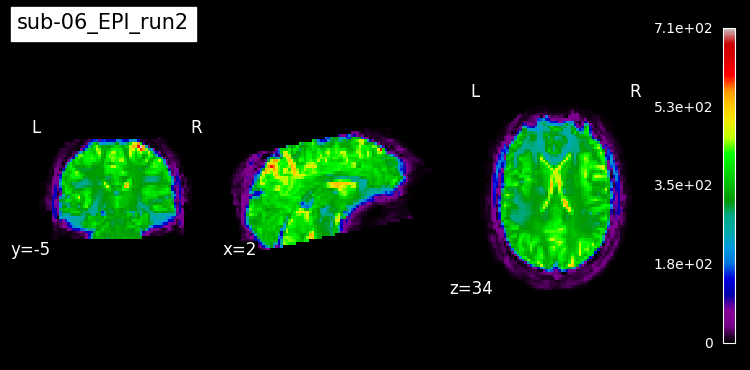

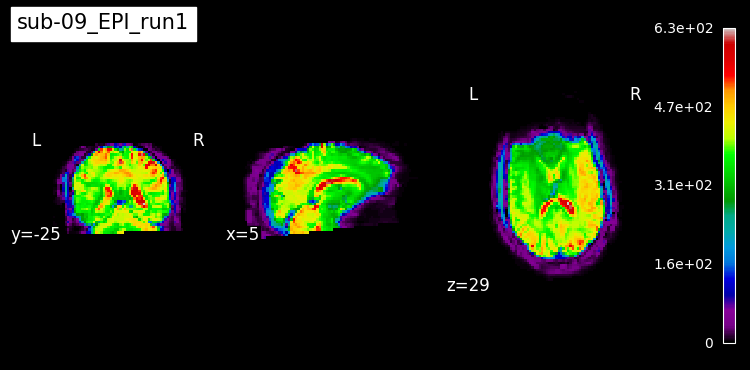

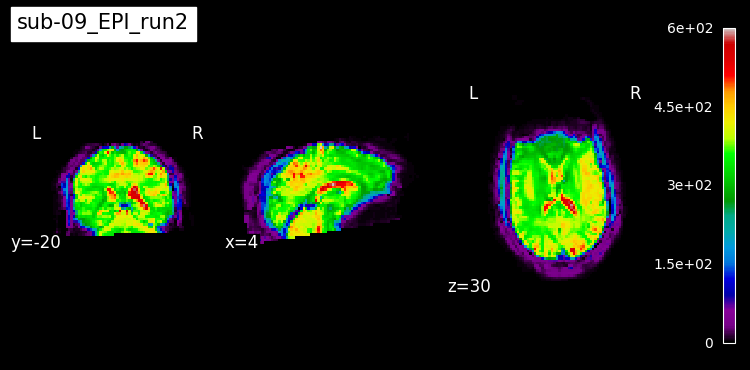

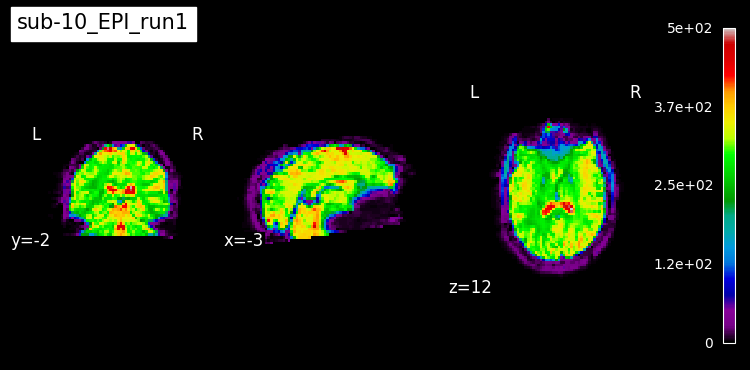

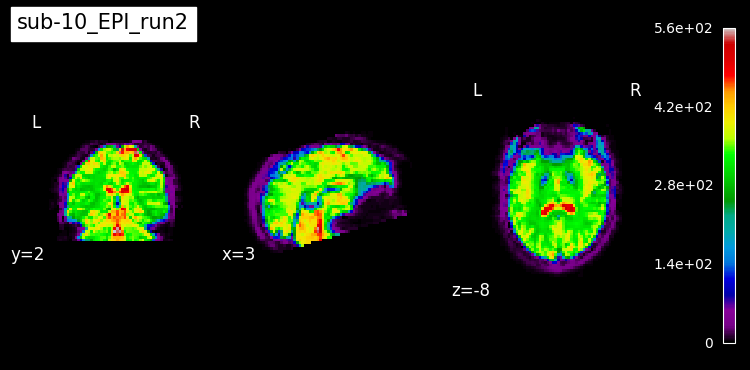

In [5]:
for sub in subject_list:
    epi1 = glob.glob(os.path.join(pp,sub,'mean_img',sub,'mean_img_run_1','*'))
    epi2 = glob.glob(os.path.join(pp,sub,'mean_img',sub,'mean_img_run_2','*'))
    plotting.plot_epi(epi1[0], title="sub-"+sub+"_EPI_run1",colorbar=True,draw_cross=False)
    plotting.plot_epi(epi2[0], title="sub-"+sub+"_EPI_run2",colorbar=True,draw_cross=False)

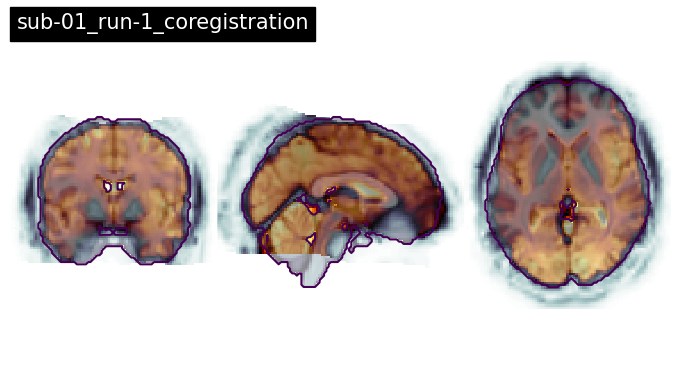

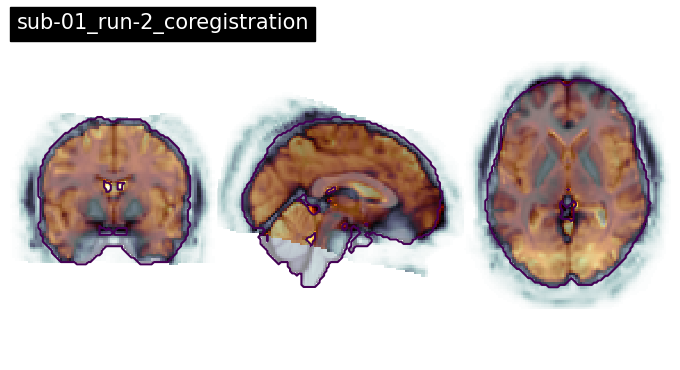

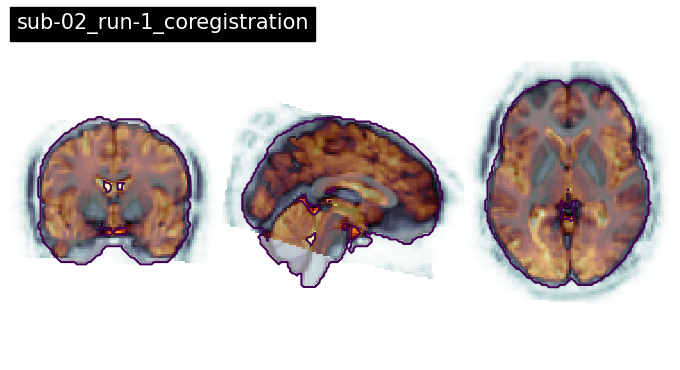

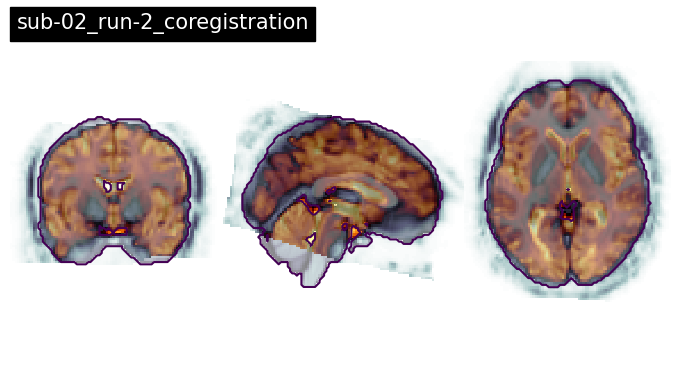

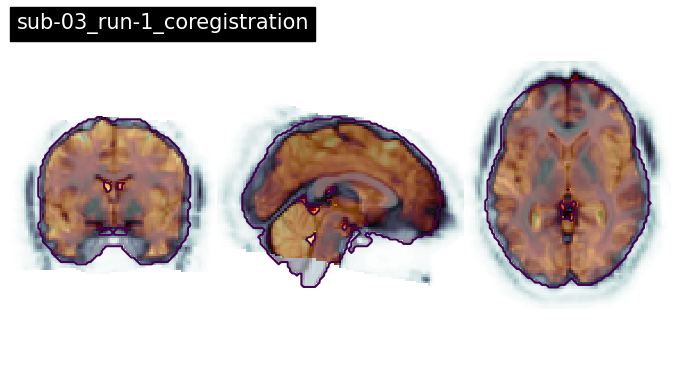

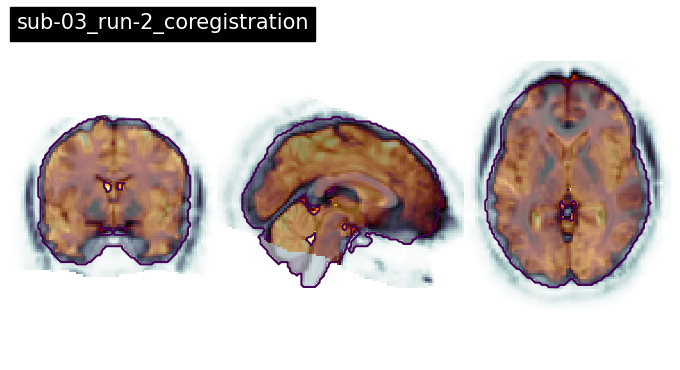

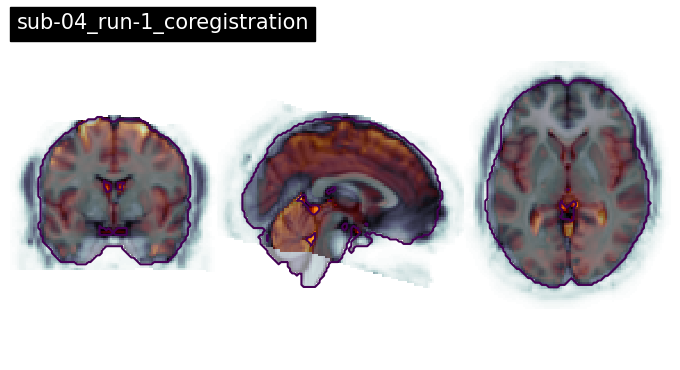

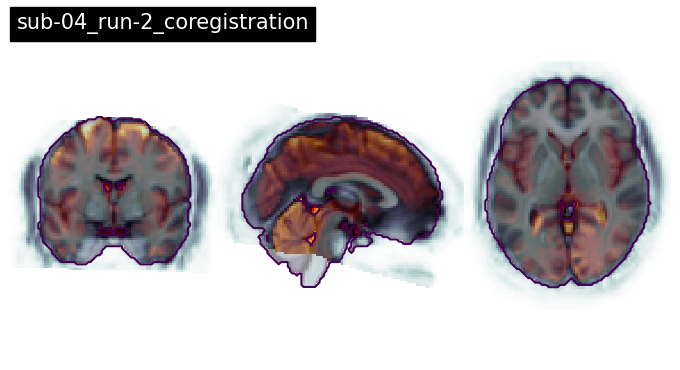

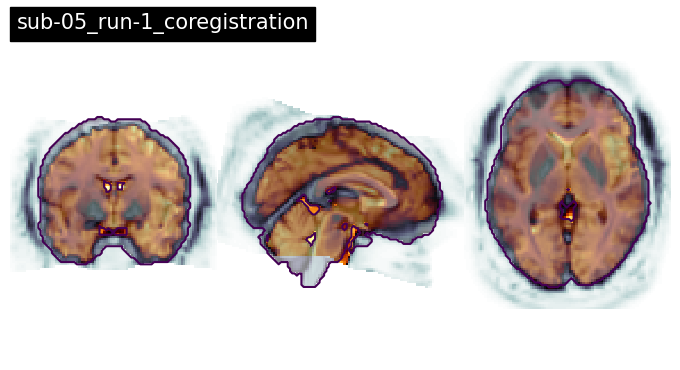

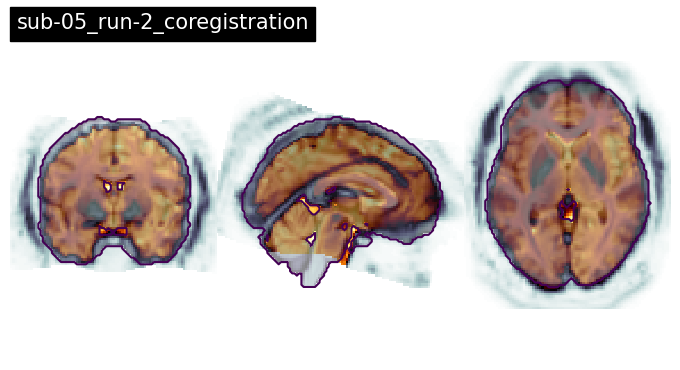

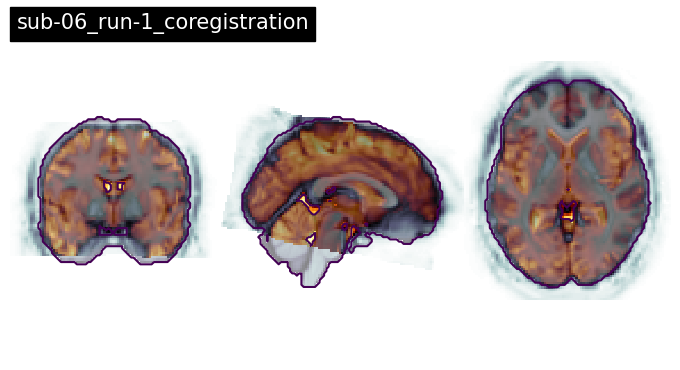

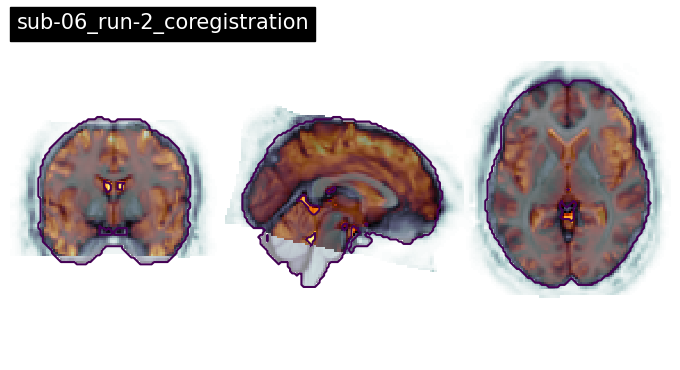

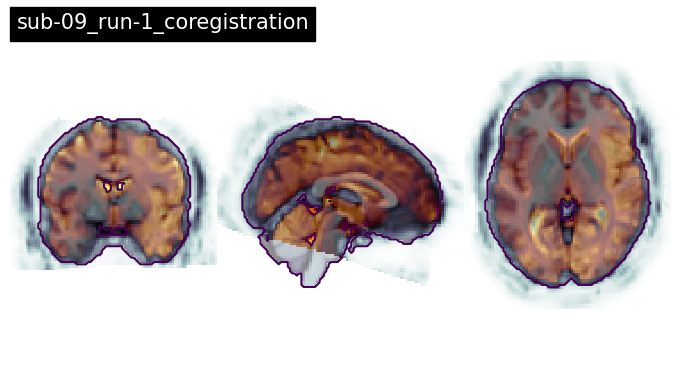

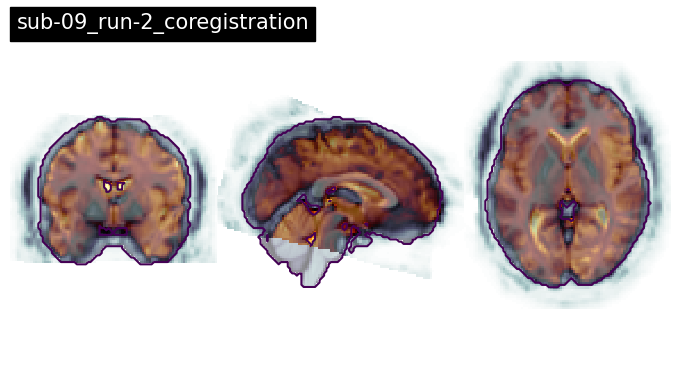

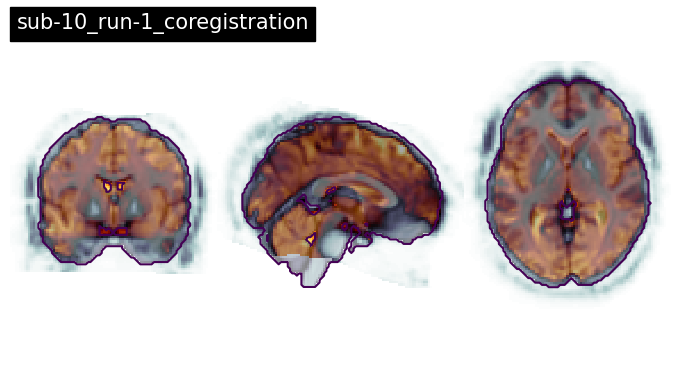

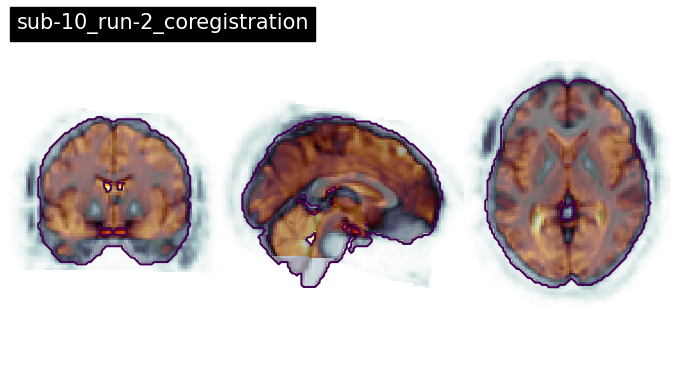

In [6]:
# cheking coregistration
# we will check the coregistration of functional and anatomical files after being normalized to MNI space.
# for that,calculate the warped (transformed) epi img and display it on top of the MNI template.
# this takes some time, we will limit it to the first 3 subjects for now

# MNI template
brain_mask = r"/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz"
# iterate over subjects
for sub in subject_list:
    # iterate over runs
    for run in range(1,num_of_runs+1):
        # paths for files 
        func_file = f'sub-{sub}_task-sync_run-{run}_bold_maths_roi_mcf_warp.nii.gz'
        func_path = os.path.join(pp, sub, 'func_warp', sub, f'func_warp_run_{run}', func_file)
        # loading
        anat_img = nib.load(brain_mask)
        func_img = nib.load(func_path)
        epi = image.mean_img(func_img)
        # plot epi
        title_str = f'sub-{sub}_run-{run}_coregistration'
        display = plotting.plot_epi(epi_img=epi, title= title_str, display_mode='ortho',
                                    annotate=False, draw_cross=False, black_bg=False,
                                    cut_coords =(0,0,0), cmap='hot_black_bone_r') 
        
        # plot MNI template and use contours to make it pop!
        display.add_overlay(anat_img,cmap='bone', alpha=0.5)       
        display.add_contours(anat_img, color='r',levels=[1])

In [7]:
# lets plot individual subjects carpet-plots, segmented by tissue type. 
# carpet plots are basically a figure that uses color intensity from white to black to indicate magnitude 
# (BOLD signal) over time of the recording
# we will make a function that takes in the directory path and prints it for each subject and for each run

def plot_carpet(dir_path,sub_list):
    from nilearn.plotting import plot_carpet
    gm = datasets.load_mni152_gm_template()
    wm = datasets.load_mni152_wm_template()
    
    atlas_img = image.concat_imgs((gm, wm))
    map_labels = {"Gray Matter": 1, "White Matter": 2}
    atlas_data = atlas_img.get_fdata()
    discrete_version = np.argmax(atlas_data, axis=3) + 1
    discrete_version[np.max(atlas_data, axis=3) == 0] = 0
    discrete_atlas_img = image.new_img_like(atlas_img, discrete_version)
    
    for sub in sub_list:
        for run in range(1,num_of_runs+1):
            # load functional file
            func_file = f'sub-{sub}_task-sync_run-{run}_bold_maths_roi_mcf_warp.nii.gz'
            func_path = os.path.join(dir_path, sub, 'func_warp', sub, f'func_warp_run_{run}', func_file)
            func_img = nib.load(func_path)
            # plot carpet
            fig, ax = plt.subplots(figsize=(10, 5))
            display = plot_carpet(func_img,
                                  discrete_atlas_img,
                                  t_r = 2,
                                  mask_labels=map_labels,
                                  axes=ax,
                                  cmap="gray",
                                  standardize="zscore_sample",
                                  title = f'sub-{sub}-run-{run}')

            fig.show()

Coercing atlas_values to <class 'int'>
Coercing atlas_values to <class 'int'>


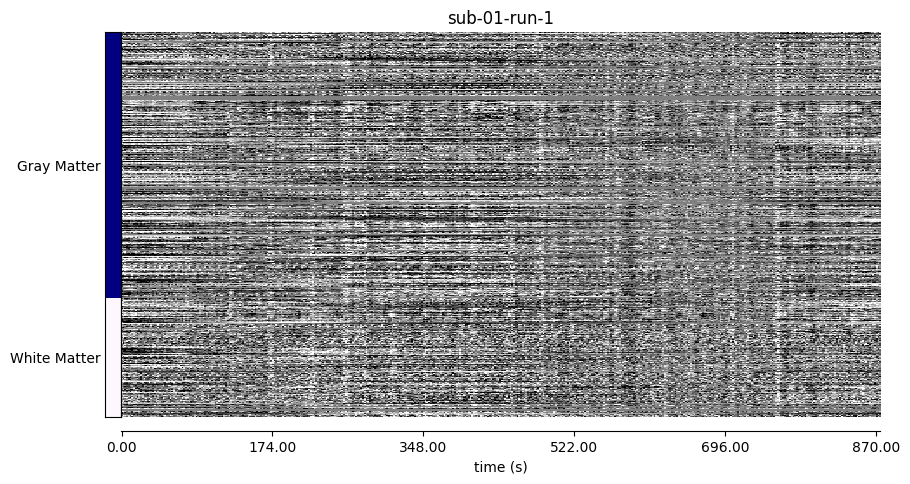

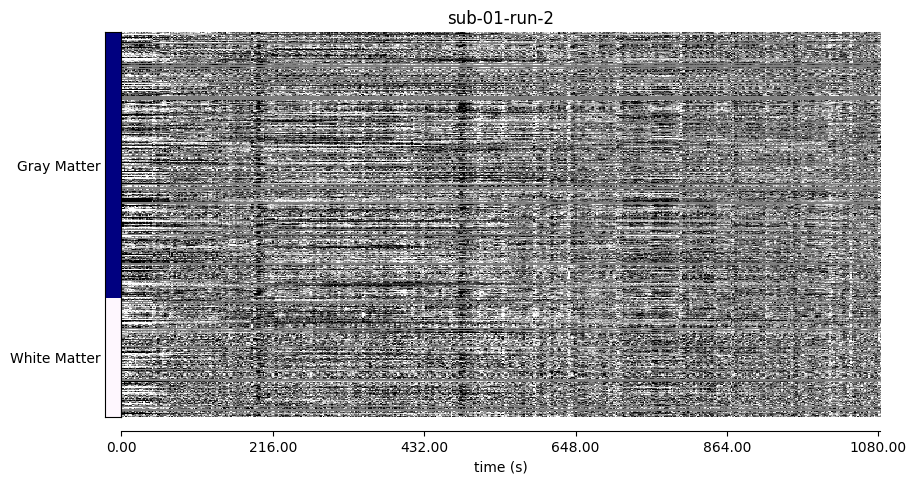

In [8]:
plot_carpet(pp,subject_list[:1]) # 1 subjects, 2 runs

In [9]:
# we will load the some png:
# - the model (in our case - all subjects had the same predictors and model so we can load from one subject)
model_path1 = os.path.join(level1, 'model', sub, 'modelgen_run_1', 'run0.png')
model_path2 = os.path.join(level1, 'model', sub, 'modelgen_run_2', 'run0.png')
model_img1 = Image.open(model_path1)
model_img1.show()

model_img2 = Image.open(model_path2)
model_img2.show()

In [10]:
# - ART (movement outlier detection) output
# we will check one subject (01).

art_path1 = os.path.join(pp,'01','art','01','art_run_1', 'plot.sub-01_task-sync_run-1_bold_maths_roi_mcf.png')
art_path2 = os.path.join(pp,'01','art','01','art_run_2', 'plot.sub-01_task-sync_run-2_bold_maths_roi_mcf.png')
art_img1 = Image.open(art_path1)
art_img1.show()

model_img2 = Image.open(art_path2)
model_img2.show()